In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
%matplotlib inline

In [2]:
df_freight = pd.read_csv('data/freight_cost.csv')
df_oil = pd.read_csv('data/monthly_oil_cost_1988-2025.csv')

In [3]:
df_freight = df_freight.drop(['Open', 'High', 'Low', 'Vol.', 'Change %'], axis=1)
df_freight["Date"] = pd.to_datetime(df_freight["Date"], format="%m/%d/%Y").dt.strftime("%d/%m/%Y")

df_oil = df_oil.drop(['Open', 'High', 'Low', 'Vol.', 'Change %'], axis=1)
df_oil["Date"] = pd.to_datetime(df_oil["Date"], format="%m/%d/%Y").dt.strftime("%d/%m/%Y")

df_freight.head(5)
df_oil.head(10)

,Date,Price
0,01/03/2025,70.88
1,01/02/2025,72.81
2,01/01/2025,75.67
3,01/12/2024,74.24
4,01/11/2024,71.84
5,01/10/2024,72.81
6,01/09/2024,71.77
7,01/08/2024,76.93
8,01/07/2024,80.84
9,01/06/2024,85.00


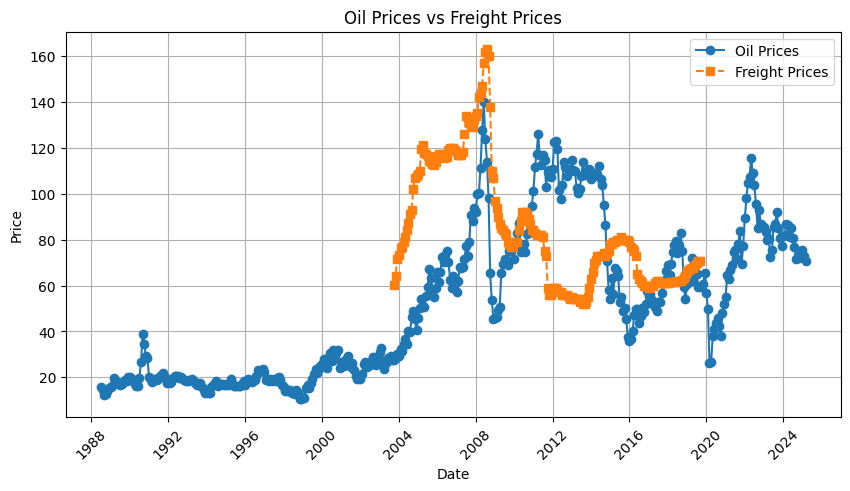

In [4]:
df_oil["Date"] = pd.to_datetime(df_oil["Date"], format="%d/%m/%Y")
df_freight["Date"] = pd.to_datetime(df_freight["Date"], format="%d/%m/%Y")

df_oil = df_oil.sort_values(by="Date")
df_freight = df_freight.sort_values(by="Date")

# Строим график
plt.figure(figsize=(10, 5))
plt.plot(df_oil["Date"], df_oil["Price"], marker="o", linestyle="-", label="Oil Prices")
plt.plot(df_freight["Date"], df_freight["Price"], marker="s", linestyle="--", label="Freight Prices")

# Оформление
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Oil Prices vs Freight Prices")
plt.legend()
plt.grid()

# Показать график
plt.xticks(rotation=45)
plt.show()

In [5]:
merged_df = pd.merge(df_oil, df_freight, on="Date", suffixes=("_Oil", "_Freight"))

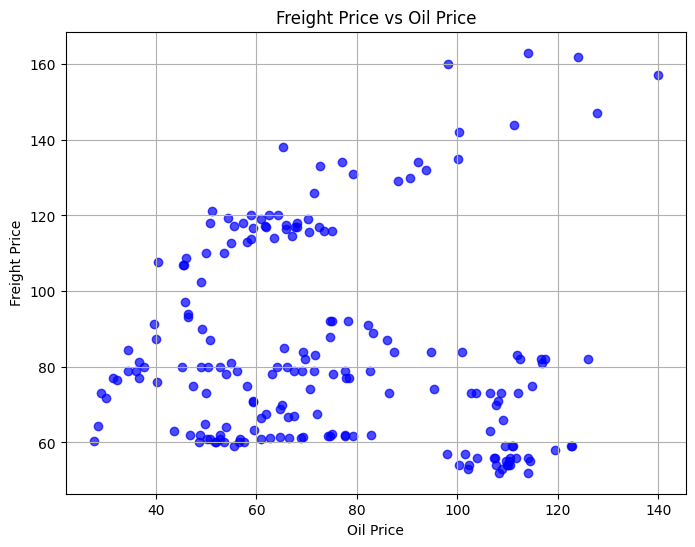

In [6]:
plt.figure(figsize=(8, 6))
plt.scatter(merged_df["Price_Oil"], merged_df["Price_Freight"], color="b", alpha=0.7)

# Оформление
plt.xlabel("Oil Price")
plt.ylabel("Freight Price")
plt.title("Freight Price vs Oil Price")
plt.grid(True)

# Показать график
plt.show()

In [8]:
import seaborn as sns
# sns.heatmap(merged_df.drop('Date', axis=1).corr(), annot=True, cmap='coolwarm',)

ModuleNotFoundError: No module named 'seaborn'

In [36]:
# np.cov(merged_df.drop(['Date'],axis=1).T)

In [9]:
import numpy as np
import seaborn as sns
import statsmodels.api as sm

# Делаем полиномиальную регрессию 2-й степени (квадратичную)
x = merged_df["Price_Oil"]
y = merged_df["Price_Freight"]

# Добавляем квадратный член
X_poly = np.column_stack((x, x**2))
X_poly = sm.add_constant(X_poly)  # Добавляем константу для свободного члена

# Обучаем модель
model = sm.OLS(y, X_poly).fit()

# Генерируем предсказания
x_range = np.linspace(min(x), max(x), 100)
X_pred = np.column_stack((x_range, x_range**2))
X_pred = sm.add_constant(X_pred)
y_pred = model.predict(X_pred)

# Строим график
plt.figure(figsize=(8, 6))
plt.scatter(x, y, color="b", alpha=0.7, label="Data")
plt.plot(x_range, y_pred, color="r", linewidth=2, label="Quadratic Fit")

# Оформление
plt.xlabel("Oil Price")
plt.ylabel("Freight Price")
plt.title("Quadratic Regression: Freight Price vs Oil Price")
plt.legend()
plt.grid(True)

# Показать график
plt.show()

# Выводим статистику модели
model.summary()

ModuleNotFoundError: No module named 'seaborn'

In [10]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Разделение данных на тренировочную и тестовую выборки
X = merged_df[["Price_Oil"]]
y = merged_df["Price_Freight"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создание и обучение модели XGBoost
xgb_model = XGBRegressor(objective="reg:squarederror", n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
xgb_model.fit(X_train, y_train)

# Предсказания на тестовой выборке
y_pred = xgb_model.predict(X_test)

# Оценка модели
mse = mean_squared_error(y_test, y_pred)

# График предсказаний
plt.figure(figsize=(8, 6))
plt.scatter(X_train, y_train, color="b", alpha=0.6, label="Train Data")
plt.scatter(X_test, y_test, color="r", alpha=0.7, label="Test Data")
plt.scatter(X_test, y_pred, color="g", marker="x", s=100, label="Predictions")

plt.xlabel("Oil Price")
plt.ylabel("Freight Price")
plt.title(f"XGBoost Regression (MSE: {mse:.2f})")
plt.legend()
plt.grid(True)

# Показать график
plt.show()

ModuleNotFoundError: No module named 'xgboost'

In [11]:
residuals = y_test - y_pred
X_resid = sm.add_constant(y_pred)  # Добавляем константу для регрессии

# Модель: residuals ~ predicted
model_resid = sm.OLS(residuals, X_resid).fit()
resid_pred = model_resid.predict(X_resid)

# График: остатки и их регрессия
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, color='purple', alpha=0.6, label='Residuals')
plt.plot(y_pred, resid_pred, color='red', linewidth=2, label='Residual Regression')

plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.xlabel("Predicted Freight Price")
plt.ylabel("Residuals")
plt.title("Regression of Residuals on Predictions")
plt.legend()
plt.grid(True)
plt.show()

# Статистика регрессии остатков
print(model_resid.summary())

NameError: name 'y_test' is not defined

In [12]:
merged_df["Oil_Lag1"] = merged_df["Price_Oil"].shift(1)
merged_df["Freight_Lag1"] = merged_df["Price_Freight"].shift(1)
merged_df["Oil_Change"] = merged_df["Price_Oil"].diff()
merged_df["Month"] = merged_df["Date"].dt.month
merged_df.dropna(inplace=True)

print(merged_df.head(5))

# Разделение
features = ['Price_Oil', 'Open_Oil', 'High_Oil', 'Low_Oil', 'Vol._Oil',
       'Change %_Oil', 'Open_Freight', 'High_Freight',
       'Low_Freight', 'Vol._Freight', 'Change %_Freight', 'Oil_Lag1',
       'Freight_Lag1', 'Oil_Change', 'Month']
X = merged_df[features]
y = merged_df["Price_Freight"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучение
model = XGBRegressor(objective="reg:squarederror", n_estimators=50, 
                     learning_rate=0.1, max_depth=2, seed=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
residuals = y_test - y_pred

# График остатков
plt.figure(figsize=(8, 6))
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.scatter(y_pred, residuals, color='green', alpha=0.7)
plt.xlabel("Predicted Freight Price")
plt.ylabel("Residuals")
plt.title("Residuals After Feature Engineering")
plt.grid(True)
plt.show()

        Date  Price_Oil  Price_Freight  Oil_Lag1  Freight_Lag1  Oil_Change  \
1 2003-11-01      28.45          64.22     27.70         60.28        0.75   
2 2003-12-01      30.17          71.69     28.45         64.22        1.72   
3 2004-01-01      29.18          73.19     30.17         71.69       -0.99   
4 2004-02-01      32.23          76.46     29.18         73.19        3.05   
5 2004-03-01      31.51          76.96     32.23         76.46       -0.72   

   Month  
1     11  
2     12  
3      1  
4      2  
5      3  


KeyError: "['Open_Oil', 'High_Oil', 'Low_Oil', 'Vol._Oil', 'Change %_Oil', 'Open_Freight', 'High_Freight', 'Low_Freight', 'Vol._Freight', 'Change %_Freight'] not in index"

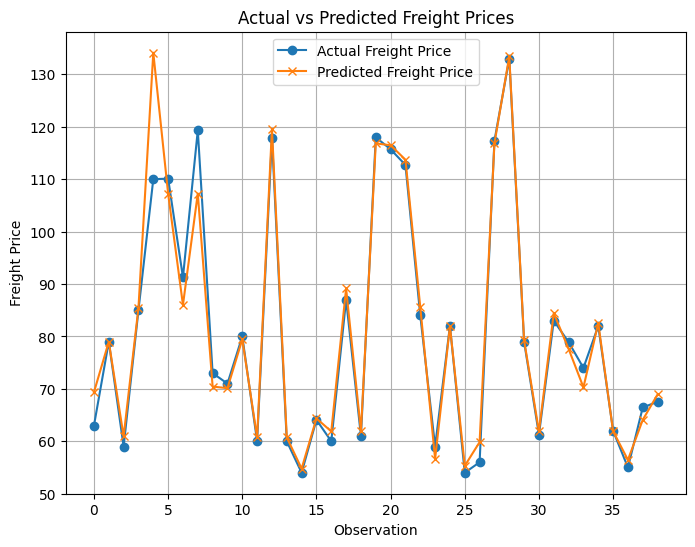

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(y_test.values, label="Actual Freight Price", marker='o')
plt.plot(y_pred, label="Predicted Freight Price", marker='x')

plt.xlabel("Observation")
plt.ylabel("Freight Price")
plt.title("Actual vs Predicted Freight Prices")
plt.legend()
plt.grid(True)
plt.show()